### Load packages and read tables.

In [2]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# This section requires full records of matches played during the observation period.
# However, I am temporarily using match records between March 1 and March 3 due to the size limit.
td = spark.read.parquet("/tmp/dt_for_cheater_analysis.parquet")
players = spark.sql("SELECT * FROM td_nodes")

# Register DataFrames as temp tables so that we can query it using SQL.
td.registerTempTable("td")
players.registerTempTable("players")

### Count the number of days players played the game.

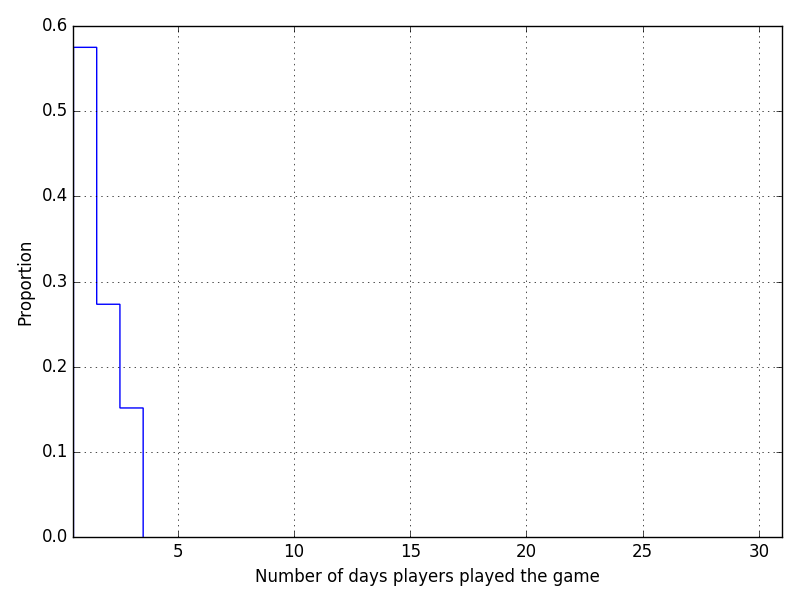

In [4]:
kill_logs = spark.sql("SELECT mid, src, dst, time, m_date FROM td t JOIN players p ON t.src = p.id")
kill_logs.registerTempTable("kill_logs")

# Calculate the number of kills of each player by date.
kills_by_date = spark.sql("SELECT src AS id, m_date, COUNT(*) AS kills FROM kill_logs GROUP BY src, m_date")
kills_by_date_df = kills_by_date.toPandas()

# Create a dataframe that stores death counts of players.
death_logs = spark.sql("SELECT mid, src, dst, time, m_date FROM td t JOIN players p ON t.dst = p.id")
death_logs.registerTempTable("death_logs")

# Calculate the number of deaths of each cheater by date.
deaths_by_date = spark.sql("SELECT dst AS id, m_date, COUNT(*) AS deaths FROM death_logs GROUP BY dst, m_date")
deaths_by_date_df = deaths_by_date.toPandas()

temp_kills = kills_by_date_df[['id', 'm_date']]
temp_deaths = deaths_by_date_df[['id', 'm_date']]
temp = pd.concat([temp_kills, temp_deaths])
temp = temp.drop_duplicates(subset=['id', 'm_date'])
# print(temp)

temp = spark.createDataFrame(temp)
temp.registerTempTable("temp")
days = spark.sql("SELECT id, COUNT(*) AS days FROM temp GROUP BY id")
# display(days)

days_df = days.toPandas()

# Calculate the mean and median number of days.
# print(days_df['days'].mean())
# print(days_df['days'].median())

# Plot the distribution of days players played the game.
bins = np.arange(0, days_df['days'].max() + 1.5) - 0.5
fig = days_df.hist(column = 'days', histtype='step', 
                   weights=np.zeros_like(days_df['days'])+1./len(days_df['days']), bins = bins)
plt.xlim(xmin=0.5)
plt.xlim(xmax=31)
plt.xlabel("Number of days players played the game")
plt.ylabel("Proportion")
plt.title("")
plt.tight_layout()
image = plt.show() 
display(image)

### Count the number of victimisation experiences.

In [6]:
# Read the information of cheaters.
cheaters = spark.read.parquet("/tmp/cheater_info.parquet")
cheaters.registerTempTable("cheaters")

# Add the cheating flag of killer for each record.
add_cheater_info = spark.sql("""SELECT mid, src, CASE WHEN m_date >= start_date AND start_date != 'NA' THEN 1 ELSE 0 END AS src_flag, dst 
                                FROM td t JOIN cheaters c ON t.src = c.id""")
add_cheater_info.registerTempTable("add_cheater_info")
# display(add_cheater_info)

# Count the number of records for each pair of killer and victim.
vic_tab = spark.sql("SELECT src, dst, COUNT(*) AS kills FROM add_cheater_info WHERE src_flag == 1 GROUP BY src, dst")
vic_tab.registerTempTable("vic_tab")
# display(vic_tab)

# Count the number of victimisation experiences of each victim.
vic_exp = spark.sql("SELECT dst, SUM(kills) AS total_vic_exp FROM vic_tab GROUP BY dst")
vic_exp.registerTempTable("vic_exp")
# display(vic_exp)

# Create a table that contains the number of victimisation experiences of each player in the dataset.
nodes = spark.sql("SELECT id FROM td_nodes")
nodes.registerTempTable("nodes")
total_vic_exp = spark.sql("""SELECT n.id, CASE WHEN total_vic_exp IS NULL THEN 0 ELSE total_vic_exp END AS total_vic_exp 
                             FROM nodes n LEFT JOIN vic_exp v ON n.id = v.dst""")
display(total_vic_exp)
# total_vic_exp_df = total_vic_exp.toPandas()
# print(total_vic_exp_df)

# Plot the distribution of victimisation experiences.
# bins = np.arange(0, total_vic_exp_df['total_vic_exp'].max() + 1.5) - 0.5
# fig = total_vic_exp_df.hist(column = 'total_vic_exp', histtype='step', 
#                             weights=np.zeros_like(total_vic_exp_df['total_vic_exp'])+1./len(total_vic_exp_df['total_vic_exp']))
# plt.xlabel("Number of victimisation experiences")
# plt.ylabel("Proportion")
# plt.title("")
# image = plt.show() 
# display(image)

# Print a list of players who have been harmed by cheating at least once.
# print(total_vic_exp_df[total_vic_exp_df['total_vic_exp'] >= 1])

dst,total_vic_exp
account.c9e48986e0dd4f90b6ac3fd881c37b12,1
account.809aed385c55484097129d1f931d81db,1
account.5f60bf73915c4318ad0705cf03c0d59a,1
account.f7cd513cf4224eceacd75e4cb86f8dff,1
account.c238e9a1e76f4b07b4e7c2d8330a2a3f,1
account.a9ddb5f546d64faaad6db35d4b3642c7,1
account.110a883639ec4c01ba40f12ae28b2508,1
account.15e50e10517747be96e1bef4fc5d00d9,1
account.2355b555855049228467c6e5313ef8d6,1
account.0bbd2655be2e4a6e81dcb604e675733a,1


### Check the number of cheaters per match.

In [8]:
# First, get a list of participants.
participants = spark.sql("""SELECT mid, m_date, dst AS id FROM td GROUP BY mid, m_date, dst 
                            UNION 
                            SELECT mid, m_date, src FROM td GROUP BY mid, m_date, src ORDER BY mid""")
participants.registerTempTable("participants")

# Get a node table that contains the start date of cheating for each cheater.
nodes = spark.sql("""SELECT t.id, t.pname, CASE WHEN c.start_date IS NULL THEN 0 ELSE 1 END AS cheating_flag, 
                     CASE WHEN c.start_date IS NULL THEN 'NA' ELSE c.start_date END AS start_date, 
                     CASE WHEN c.ban_date IS NULL THEN 'NA' ELSE c.ban_date END AS ban_date 
                     FROM td_nodes t LEFT JOIN cheaters c ON t.id = c.id""")
nodes.registerTempTable("nodes")

# Add cheating flags of cheaters.
players_with_cheater_info = spark.sql("""SELECT mid, m_date, p.id, 
                                         CASE WHEN m_date >= start_date AND cheating_flag = 1 THEN 1 ELSE 0 END AS flag 
                                         FROM participants p JOIN nodes n ON p.id = n.id ORDER BY mid, flag""")
# display(players_with_cheater_info)
players_with_cheater_info.registerTempTable("players_with_cheater_info")

# Calculate the number of cheaters per match.
num_of_cheaters = spark.sql("SELECT mid, SUM(flag) AS cheater_cnt FROM players_with_cheater_info GROUP BY mid")
num_of_cheaters.registerTempTable("num_of_cheaters")
num_of_cheaters = spark.sql("SELECT mid, cheater_cnt FROM num_of_cheaters WHERE cheater_cnt >= 1")
num_of_cheaters.registerTempTable("num_of_cheaters")
# display(num_of_cheaters)
# print(num_of_cheaters.count())
num_of_cheaters_df = num_of_cheaters.toPandas()

# Plot the distribution of the number of cheaters per match.
bins = np.arange(0, num_of_cheaters_df['cheater_cnt'].max() + 1.5) - 0.5
fig = num_of_cheaters_df.hist(column = 'cheater_cnt', histtype='step', bins=bins, 
                              weights=np.zeros_like(num_of_cheaters_df['cheater_cnt'])+1./len(num_of_cheaters_df['cheater_cnt']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of cheaters per match")
plt.ylabel("Proportion")
plt.title("")
image = plt.show()
display(image)

# Count the number of matches where only one cheater took part in.
print(len(num_of_cheaters_df[num_of_cheaters_df['cheater_cnt'] == 1]))

14416

### Check how it is common to be killed by the same killer more than once.

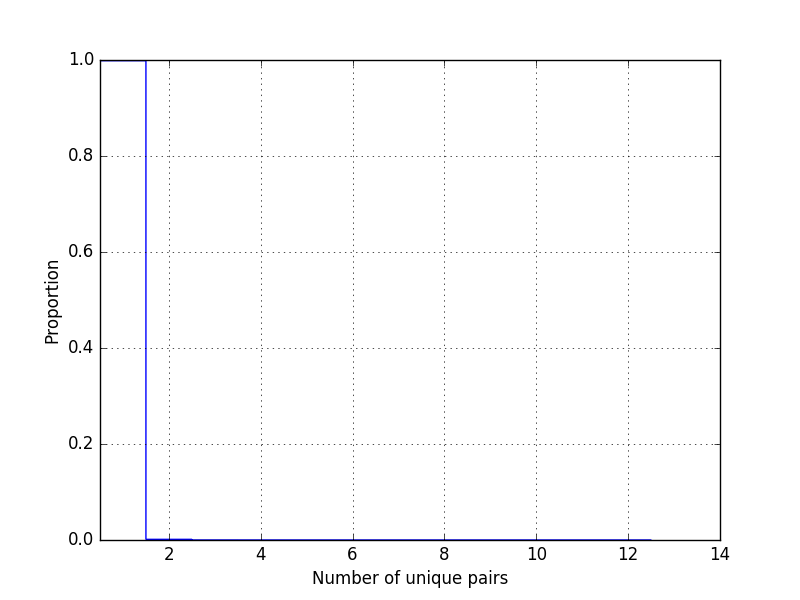

In [10]:
# Count the total number of kill records.
# print(td.count())
# The number of kill records is 12216918.

# Count the number of unique pairs of killer and victim.
pair_cnt = spark.sql("SELECT src, dst, COUNT(*) as pair_cnt FROM td GROUP BY src, dst")
# display(pair_cnt)
# print(pair_cnt.count())
# The number of unique pairs is 12198344.

pair_cnt_df = pair_cnt.toPandas()

# Plot the distribution of the number of cheaters per match.
bins = np.arange(0, pair_cnt_df['pair_cnt'].max() + 1.5) - 0.5
fig = pair_cnt_df.hist(column = 'pair_cnt', histtype='step', bins=bins, 
                       weights=np.zeros_like(pair_cnt_df['pair_cnt'])+1./len(pair_cnt_df['pair_cnt']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of occurrences of unique pairs")
plt.ylabel("Proportion")
plt.title("")
image = plt.show()
display(image)

# Count the number of matches where only one cheater took part in.
print(len(pair_cnt_df[pair_cnt_df['pair_cnt'] == 1]))
# 99.7 percent of pairs (12180711 pairs) occurred only once.

# print(pair_cnt_df['pair_cnt'].max())
# The maximum number of occurrences is 12.